# Data Wrangling - Trips

### Import Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math

import seaborn as sns
sns.set()

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [4]:
print('Loading Trip Data...')

try:
    file_path_slug = '../../../datasets/bayareabikeshare/*_trip_data.csv'

    # glob all files
    file_list = glob(file_path_slug)

    counter = 1

    # load data from each file
    for file in file_list:

        chunks = []
        chunk_counter = 1
        chunksize = 10000
        num_chunks = math.ceil(sum(1 for row in open(file, 'r'))/chunksize)

        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=chunksize, iterator=True):

            # define Columns
            chunk.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_terminal', 'end_date', 
                             'end_station_name', 'end_terminal', 'bike_id', 'subscriber_type', 'zip_code']

            # append chunk to chunks list
            chunks.append(chunk)
            
            if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
                print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
            chunk_counter += 1
            

        if counter == 1:
            trip_import_01 = pd.DataFrame()
            trip_import_01 = pd.concat(chunks)
        elif counter == 2:
            trip_import_02 = pd.DataFrame()
            trip_import_02 = pd.concat(chunks)
        elif counter == 3:
            trip_import_03 = pd.DataFrame()
            trip_import_03 = pd.concat(chunks)
        elif counter == 4:
            trip_import_04 = pd.DataFrame()
            trip_import_04 = pd.concat(chunks)
        else:
            pass


        print('Finished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1

    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')

Loading Trip Data...
	[20:50:53.420141] finished chunk 1 of 32
	[20:50:53.527104] finished chunk 4 of 32
	[20:50:53.664278] finished chunk 8 of 32
	[20:50:53.797293] finished chunk 12 of 32
	[20:50:53.929824] finished chunk 16 of 32
	[20:50:54.059943] finished chunk 20 of 32
	[20:50:54.205067] finished chunk 24 of 32
	[20:50:54.338932] finished chunk 28 of 32
	[20:50:54.450847] finished chunk 32 of 32
Finished file! (1 of 4)
	[20:50:54.680539] finished chunk 1 of 15
	[20:50:54.721026] finished chunk 2 of 15
	[20:50:54.796068] finished chunk 4 of 15
	[20:50:54.861429] finished chunk 6 of 15
	[20:50:54.942355] finished chunk 8 of 15
	[20:50:55.007500] finished chunk 10 of 15
	[20:50:55.080213] finished chunk 12 of 15
	[20:50:55.144695] finished chunk 14 of 15
	[20:50:55.160590] finished chunk 15 of 15
Finished file! (2 of 4)
	[20:50:55.460958] finished chunk 1 of 36
	[20:50:55.557389] finished chunk 4 of 36
	[20:50:55.690672] finished chunk 8 of 36
	[20:50:55.827671] finished chunk 12 of

In [5]:
trip_import_01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313689 entries, 0 to 313688
Data columns (total 11 columns):
trip_id               313689 non-null int64
duration              313689 non-null int64
start_date            313689 non-null object
start_station_name    313689 non-null object
start_terminal        313689 non-null int64
end_date              313689 non-null object
end_station_name      313689 non-null object
end_terminal          313689 non-null int64
bike_id               313689 non-null int64
subscriber_type       313689 non-null object
zip_code              313498 non-null object
dtypes: int64(5), object(6)
memory usage: 28.7+ MB


In [6]:
trip_import_01.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,subscriber_type,zip_code
0,913465,746,9/1/2015 0:10,San Francisco Caltrain 2 (330 Townsend),69,9/1/2015 0:23,San Francisco City Hall,58,238,Subscriber,94107
1,913466,969,9/1/2015 0:15,Clay at Battery,41,9/1/2015 0:31,Washington at Kearny,46,16,Subscriber,94133
2,913467,233,9/1/2015 0:15,Davis at Jackson,42,9/1/2015 0:19,Commercial at Montgomery,45,534,Subscriber,94111


## Utility Functions

In [7]:
# zipcodes are all over the place, only keep corrected 5 digit zipcodes, and replace all others with NaNs
def clean_zipcode(item):
    
    z = str(item)
    
    if len(z) != 5:

        # split on '-'
        try:
            result = z.split('-')[0]
        except:
            result = z

        # split on '.'
        try:
            result = z.split('.')[0]
        except:
            result = z
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = z
    
    # make sure result is all digits
    if result.isdigit():
        result = int(result)
        return result
    else:
        return 99999
    
def clean_trip_frame(df):
    
    # set column types
    df['start_date']       = pd.to_datetime(df['start_date'], format="%m/%d/%Y %H:%M")
    df['end_date']         = pd.to_datetime(df['end_date'],   format="%m/%d/%Y %H:%M")
    df['trip_id']          = df['trip_id'].astype('int')
    df['duration']         = df['duration'].astype('int')    
    df['start_terminal']   = df['start_terminal'].astype('int')
    df['end_terminal']     = df['end_terminal'].astype('int')
    df['bike_id']          = df['bike_id'].astype('int')
    df['subscriber_type']  = df['subscriber_type'].astype('category')
    
    # add 'duration_minutes' column
    df['duration_minutes'] = df['duration'] / 60.
    df['duration_minutes'] = df['duration_minutes'].astype('float')
    
    # Clean Zipcode
    df['zip_code'] = df.zip_code.apply(clean_zipcode)
    
    # rename columns for clarity
    df.rename(columns={'zip_code': 'user_zip', 'subscriber_type': 'user_type'}, inplace=True)

    return df

def plot_terminal_trips(df, id, date_range = (pd.Timestamp('2013-08-01'), pd.Timestamp('2016-10-01')), x_label = 'Date', y_label = 'Trips', title_suffix='', draw_dates=[]):
    
    def group_terminal(df, start=True):
        ''' group by start or end terminal trips per day
        '''
        
        term = pd.DataFrame()
        if start:
            term = df[df['start_terminal'] == id]
        else:
            term = df[df['end_terminal'] == id]
        term.set_index('start_date', inplace=True)
        g_term = term.groupby(term.index.date)['trip_id'].count()
        
        return g_term
    
        
    start_term = group_terminal(df, start=True)
    end_term   = group_terminal(df, start=False)
    
    ax = start_term.plot(kind='line', color='c', alpha=0.75, figsize=(24,3))
    end_term.plot(kind='line', color='g', alpha=0.75, ax=ax)
    
    ax.set_xlim(date_range)
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    
    ax.legend(['Start Terminal', 'End Terminal'], loc=1)
    
    if len(draw_dates) > 0:
        for xc in draw_dates:
            ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
    plt.show()
    
    
def date_fixes(df, old_terminal, new_terminal, change_date):
    
    print('[%s]\tUpdating %s to %s for dates after %s' % (datetime.datetime.now().time(), old_terminal, new_terminal, change_date))

#     t_min = pd.Timestamp('2013-05-01')
#     t_max = pd.Timestamp('2016-10-01')
    
    for station in [old_terminal, new_terminal]:
        plot_terminal_trips(df, station, title_suffix='PRE DATE FIX', draw_dates=[change_date])
        
    # Fix A to B - Start Terminal
    print('[%s]\tStarted indexing...' % datetime.datetime.now().time())
    index_to_update_start = df[(df.start_terminal == old_terminal) & (df.start_date >= change_date)].index
    df.loc[index_to_update_start, 'start_terminal'] = new_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())    

    # Fix A to B - End Terminal
    print('[%s]\tStarted Update...' % datetime.datetime.now().time())
    index_to_update_end   = df[(df.end_terminal == old_terminal) & (df.end_date >= change_date)].index
    df.loc[index_to_update_end, 'end_terminal'] = new_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())
    
    
    # Fix B to A - Start Terminal
    print('[%s]\tStarted indexing...' % datetime.datetime.now().time())
    index_to_update_start = df[(df.start_terminal == new_terminal) & (df.start_date < change_date)].index
    df.loc[index_to_update_start, 'start_terminal'] = old_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())    

    # Fix B to A - End Terminal
    print('[%s]\tStarted Update...' % datetime.datetime.now().time())
    index_to_update_end   = df[(df.end_terminal == new_terminal) & (df.end_date < change_date)].index
    df.loc[index_to_update_end, 'end_terminal'] = old_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())
    

    for station in [old_terminal, new_terminal]:
        plot_terminal_trips(df, station, draw_dates=[change_date])
    
    return df

# Clean Data

- Format zip codes to take only first 5 digits, this data is self reported and often wrongly input per Bay Area Bike Share Notes
- Prune out Trips greater than 60 minutes long
- Adjust records for station relocations and renaming

In [8]:
# clean data frames
print('[%s] Trip Data Cleanup Started' % datetime.datetime.now().time())
trip_01_clean = clean_trip_frame(trip_import_01.copy())
trip_02_clean = clean_trip_frame(trip_import_02.copy())
trip_03_clean = clean_trip_frame(trip_import_03.copy())
trip_04_clean = clean_trip_frame(trip_import_04.copy())

print('[%s] Merging Trip Data' % datetime.datetime.now().time())
trip_data = pd.DataFrame()
trip_data = pd.concat([trip_01_clean, trip_02_clean, trip_03_clean, trip_04_clean])
trip_data.drop_duplicates(inplace=True)
trip_data.sort_values('trip_id', inplace=True)
trip_data.reset_index(inplace=True, drop=True)

print('[%s] Cleanup Complete!' % datetime.datetime.now().time())

[20:50:58.624650] Trip Data Cleanup Started
[20:51:09.791380] Merging Trip Data
[20:51:11.511349] Cleanup Complete!


In [9]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983648 entries, 0 to 983647
Data columns (total 12 columns):
trip_id               983648 non-null int64
duration              983648 non-null int64
start_date            983648 non-null datetime64[ns]
start_station_name    983648 non-null object
start_terminal        983648 non-null int64
end_date              983648 non-null datetime64[ns]
end_station_name      983648 non-null object
end_terminal          983648 non-null int64
bike_id               983648 non-null int64
user_type             983648 non-null category
user_zip              983648 non-null int64
duration_minutes      983648 non-null float64
dtypes: category(1), datetime64[ns](2), float64(1), int64(6), object(2)
memory usage: 83.5+ MB


In [10]:
trip_data.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000


In [11]:
trip_data.tail(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
983645,1338406,457,2016-08-31 23:06:00,Davis at Jackson,42,2016-08-31 23:13:00,Spear at Folsom,49,504,Subscriber,94111,7.616667
983646,1338407,260,2016-08-31 23:09:00,Embarcadero at Bryant,54,2016-08-31 23:14:00,Steuart at Market,74,226,Subscriber,94114,4.333333
983647,1338408,378,2016-08-31 23:32:00,Washington at Kearny,46,2016-08-31 23:38:00,Embarcadero at Sansome,60,667,Subscriber,94111,6.300000


## Prune By Trip Duration

In [12]:
# prune data to exclude trips longer than 60 minutes
print('[%s] - Removing trips longer than 60 minutes' % (datetime.datetime.now().time()))
drop_list = trip_data[trip_data.duration_minutes > 60.0].index
print('\t\tremoving %s items' % len(drop_list))
trip_data.drop(drop_list, inplace=True)
trip_data.reset_index(inplace=True, drop=True)
print('[%s] - Complete' % (datetime.datetime.now().time()))

trip_data.info()

[20:51:12.046513] - Removing trips longer than 60 minutes
		removing 28091 items
[20:51:12.222694] - Complete
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955557 entries, 0 to 955556
Data columns (total 12 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null category
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
dtypes: category(1), datetime64[ns](2), float64(1), int64(6), object(2)
memory usage: 81.1+ MB


## Correct Relocated Stations

> There was a delay in station_id updates when stations 23, 24, 25, and 26 were relocated, update status information by changing the station_id for these stations in dates after they were relocated

[20:51:12.681006]	Updating 23 to 88 for dates after 2016-07-05 00:00:00


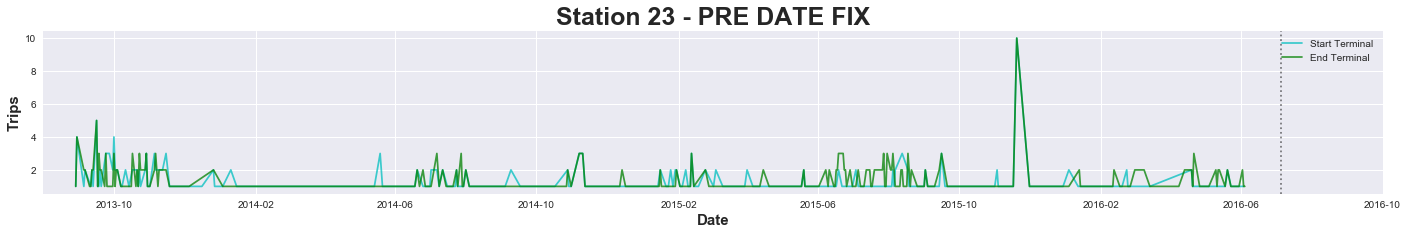

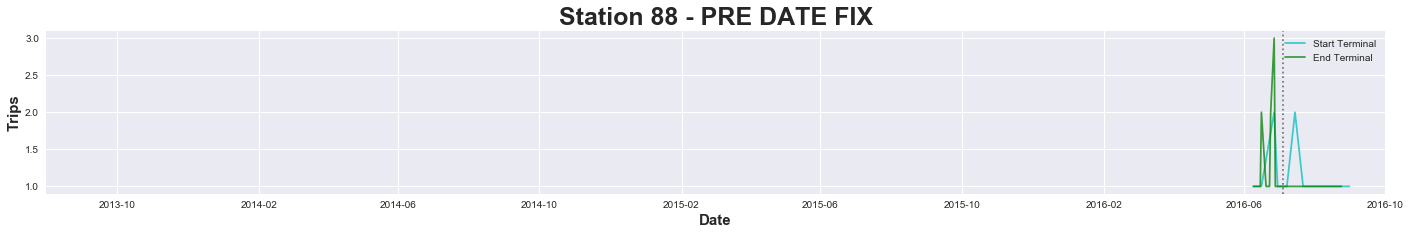

[20:51:13.515244]	Started indexing...
	[20:51:13.605478]	Complete!
[20:51:13.605636]	Started Update...
	[20:51:13.622784]	Complete!
[20:51:13.622935]	Started indexing...
	[20:51:13.639979]	Complete!
[20:51:13.640156]	Started Update...
	[20:51:13.657791]	Complete!


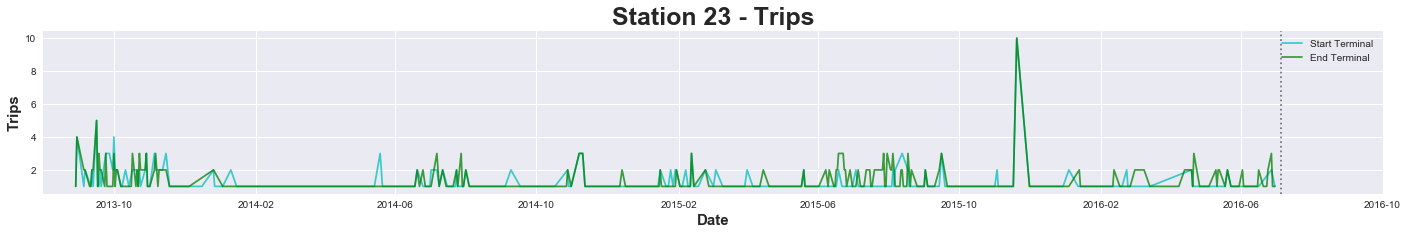

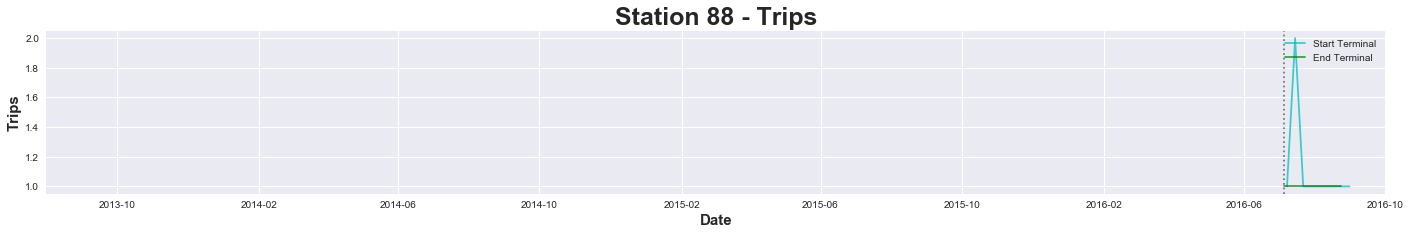

[20:51:14.162702]	Updating 24 to 89 for dates after 2016-07-05 00:00:00


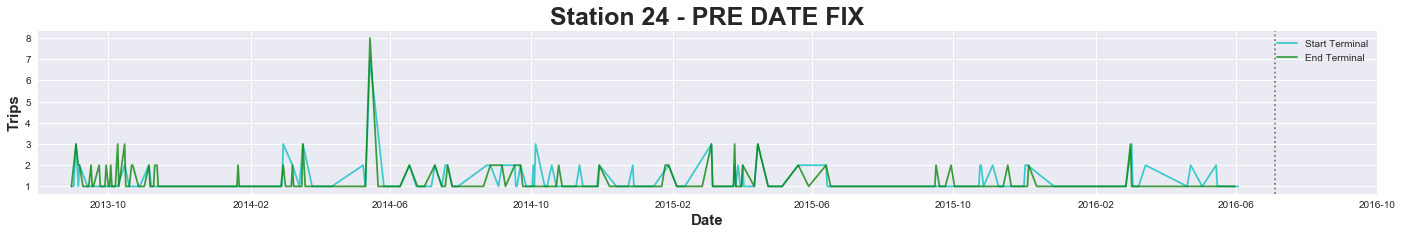

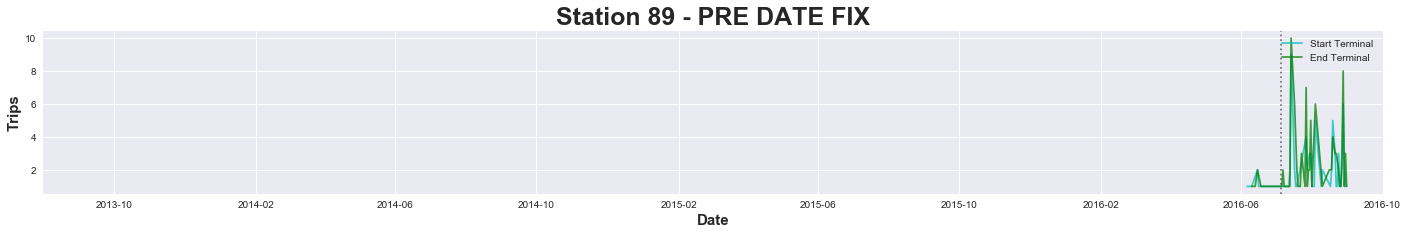

[20:51:14.671949]	Started indexing...
	[20:51:14.689404]	Complete!
[20:51:14.689544]	Started Update...
	[20:51:14.705767]	Complete!
[20:51:14.705932]	Started indexing...
	[20:51:14.722485]	Complete!
[20:51:14.722611]	Started Update...
	[20:51:14.739028]	Complete!


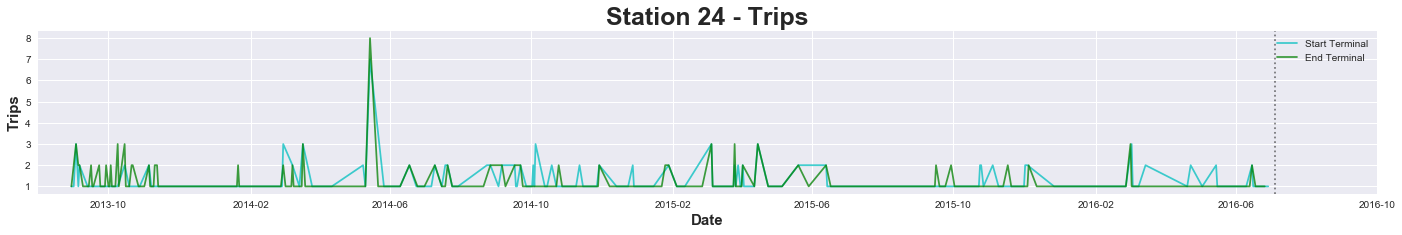

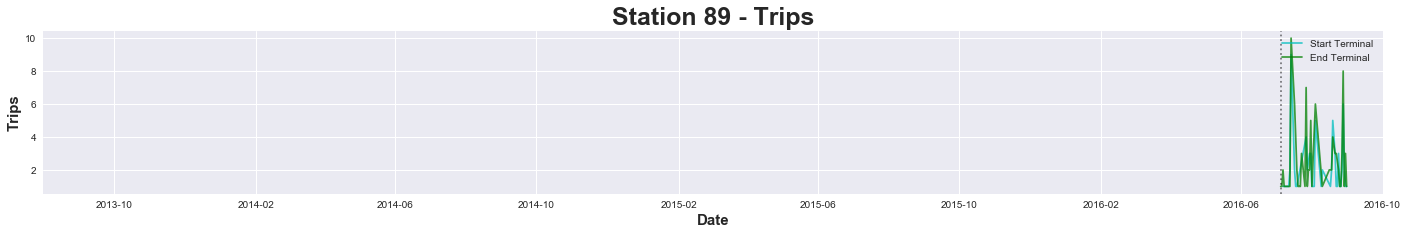

In [13]:
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
trip_data = date_fixes(trip_data, 23, 88, change_date)
trip_data = date_fixes(trip_data, 24, 89, change_date)

[20:51:15.358250]	Updating 25 to 91 for dates after 2016-08-04 00:00:00


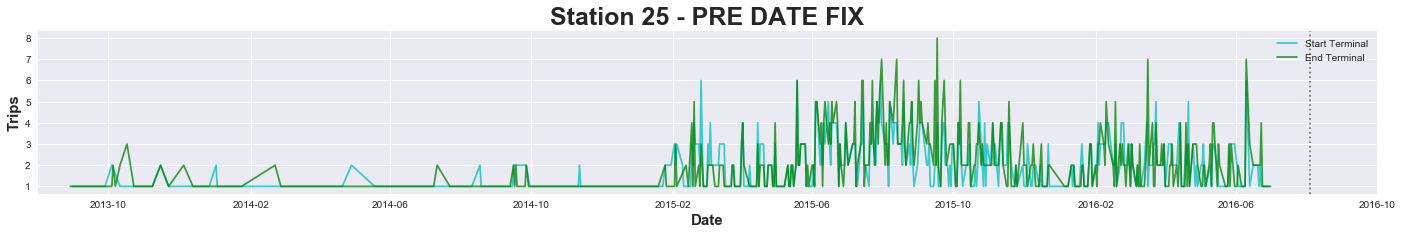

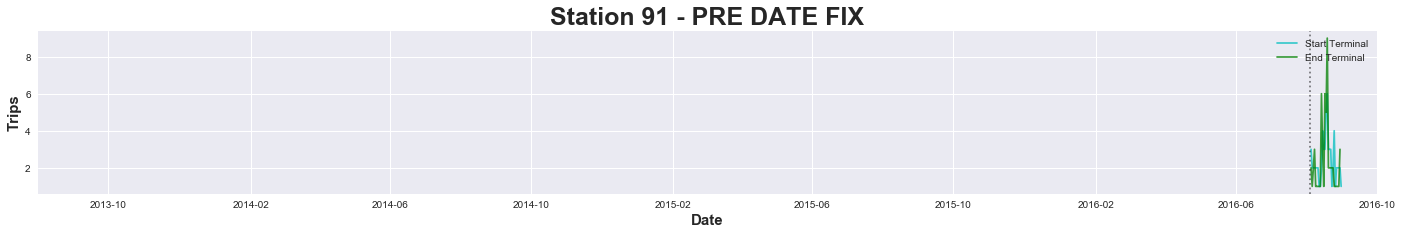

[20:51:15.988209]	Started indexing...
	[20:51:16.009732]	Complete!
[20:51:16.009995]	Started Update...
	[20:51:16.031044]	Complete!
[20:51:16.031223]	Started indexing...
	[20:51:16.050790]	Complete!
[20:51:16.050931]	Started Update...
	[20:51:16.067399]	Complete!


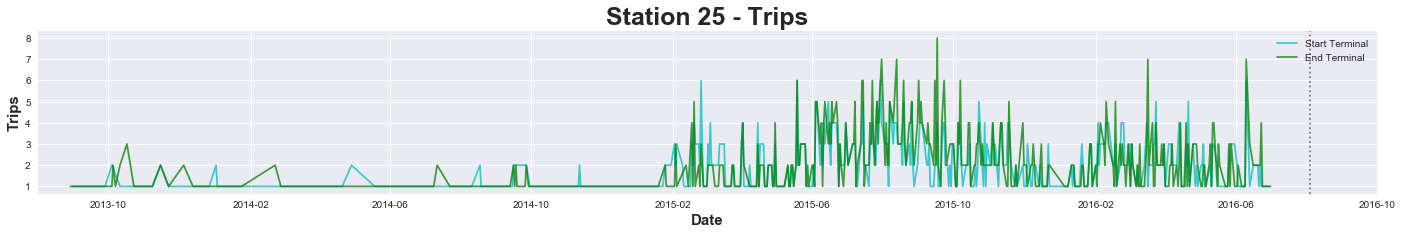

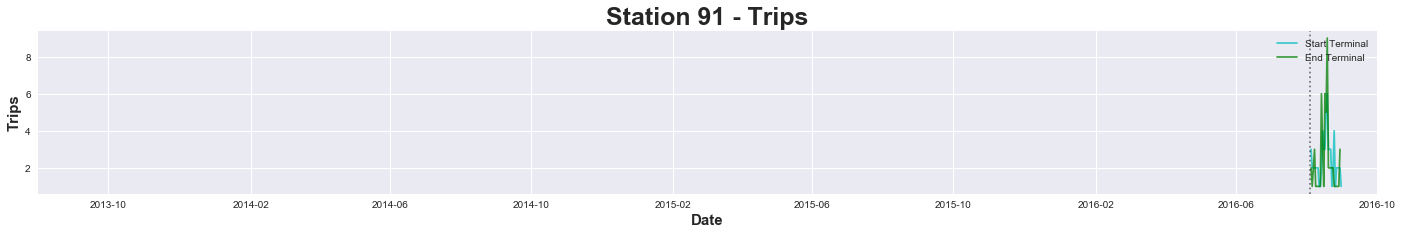

[20:51:16.587659]	Updating 26 to 90 for dates after 2016-08-04 00:00:00


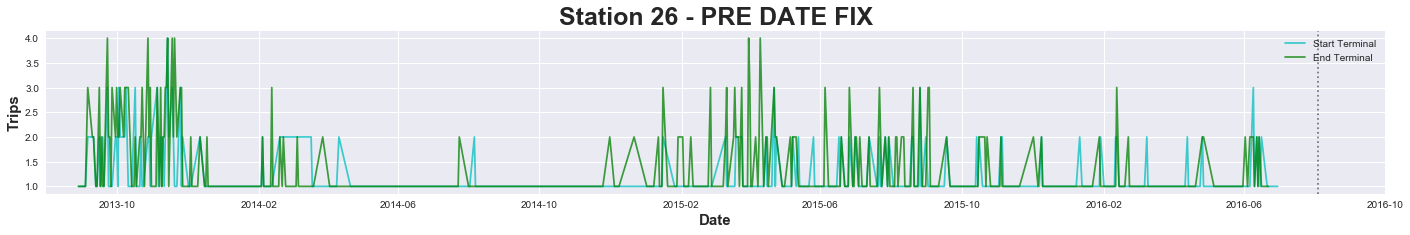

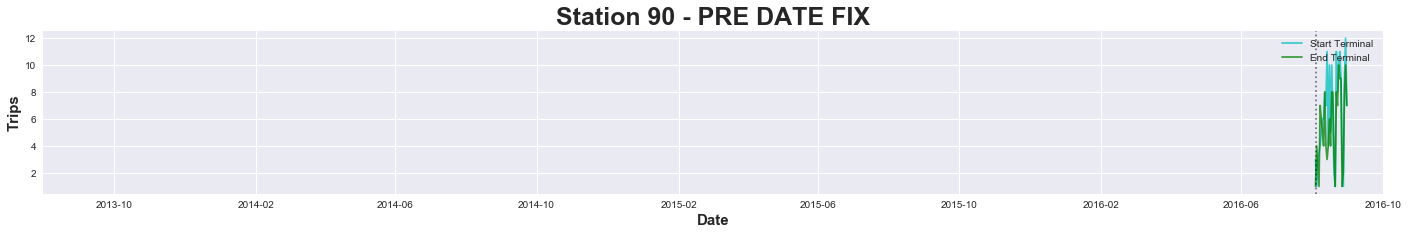

[20:51:17.157507]	Started indexing...
	[20:51:17.175226]	Complete!
[20:51:17.175523]	Started Update...
	[20:51:17.196165]	Complete!
[20:51:17.196307]	Started indexing...
	[20:51:17.211975]	Complete!
[20:51:17.212103]	Started Update...
	[20:51:17.228557]	Complete!


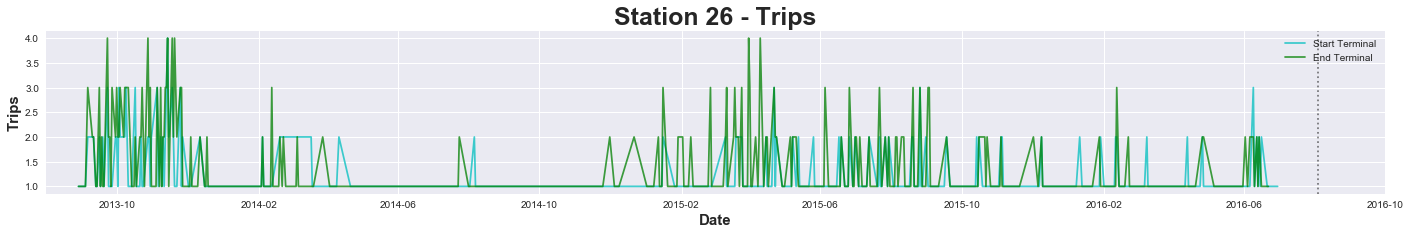

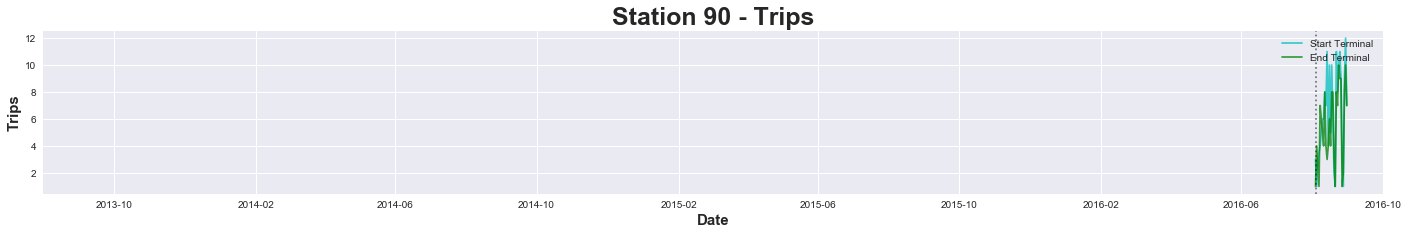

In [14]:
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
trip_data = date_fixes(trip_data, 25, 91, change_date)
trip_data = date_fixes(trip_data, 26, 90, change_date)

## Preview Graphical EDA by User Type

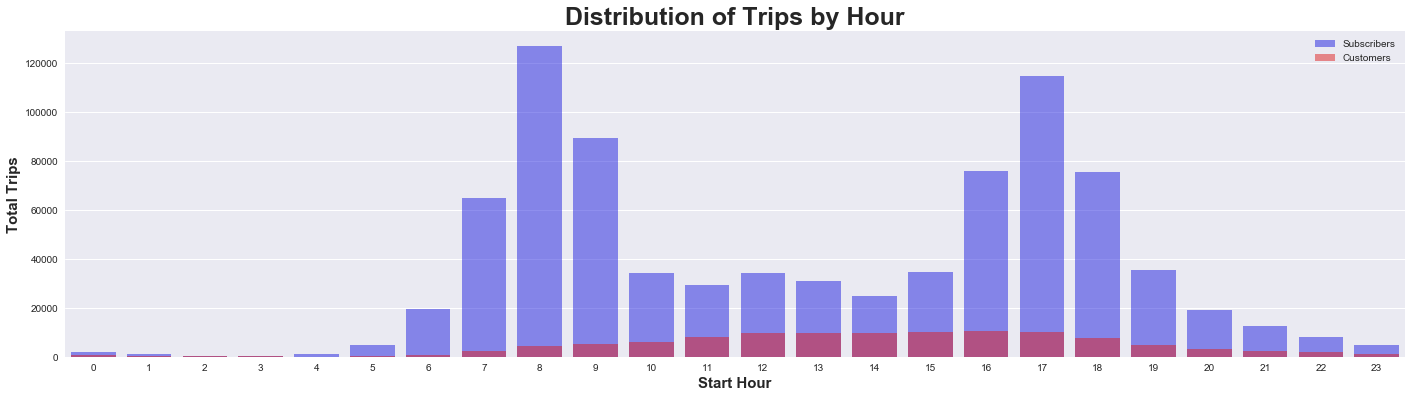

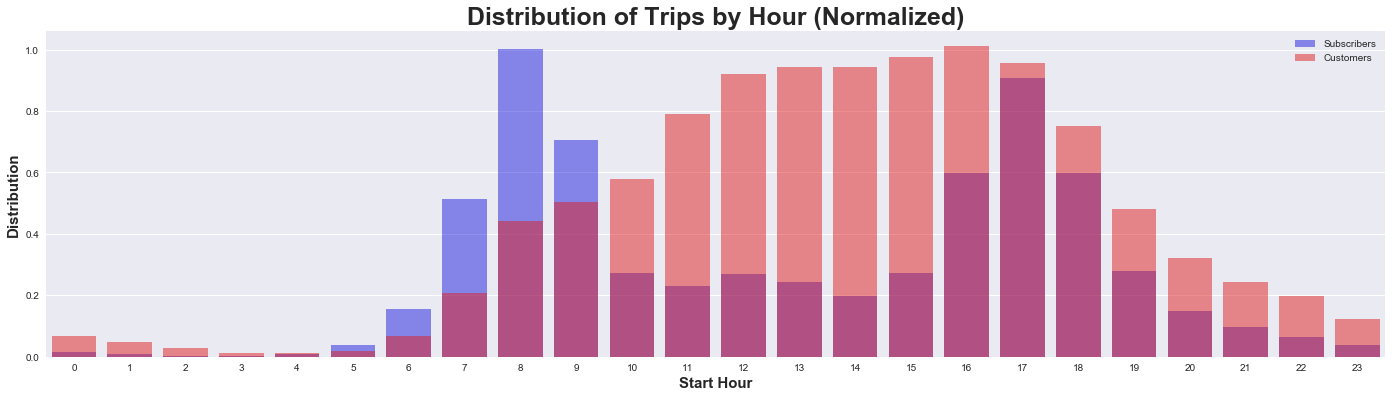

In [15]:
x_ticks = sorted(pd.unique(trip_data.start_date.dt.hour))
subscriber_y = trip_data[trip_data.user_type == 'Subscriber'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()
customer_y   = trip_data[trip_data.user_type == 'Customer'].groupby(trip_data.start_date.dt.hour)['trip_id'].count()
sub_norm  = subscriber_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))
cust_norm =   customer_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))


plt.subplots(figsize=(24,6))
ax = sns.barplot(x = x_ticks , y = subscriber_y, color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = customer_y, color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)

plt.legend()
plt.show()



plt.subplots(figsize=(24,6))
ax = sns.barplot(x = x_ticks , y = sub_norm['trip_id'], color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = cust_norm['trip_id'], color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour (Normalized)', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Distribution', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)

plt.legend()
plt.show()

In [16]:
print('[%s]\tWriting File...' % datetime.datetime.now().time())
trip_data.to_csv('../clean_data/trip_data_cleaned.csv', encoding='utf-8')
print('\t[%s]\tComplete!' % datetime.datetime.now().time())

[20:51:19.426200]	Writing File...
	[20:51:34.301499]	Complete!


# Load Station Data

In [17]:
station_data = pd.DataFrame()
station_data = pd.read_csv('../clean_data/station_data_cleaned_final.csv', parse_dates=['first_service_date', 'last_service_date'], index_col=0)

station_data_basic = pd.DataFrame()
# drop duplicated station_id ros, keep first
station_data_basic = station_data.copy()
station_data_basic.drop_duplicates(subset=['station_id'], keep='first', inplace=True)

station_data_basic.drop(['lat', 'long', 'landmark', 'zip_code'], axis=1, inplace=True)

station_data_basic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 78
Data columns (total 6 columns):
station_id            74 non-null int64
name                  74 non-null object
dock_count            74 non-null int64
first_service_date    74 non-null datetime64[ns]
last_service_date     74 non-null datetime64[ns]
days_in_service       74 non-null int64
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 4.0+ KB


### Append Service area start and end columns

In [18]:
trip_data.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000


In [19]:
station_data.head(3)

,station_id,name,lat,long,dock_count,landmark,first_service_date,last_service_date,zip_code,days_in_service
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098


In [20]:
print('[%s]\tStarting Area Lookup...' % datetime.datetime.now().time())
trip_data['start_area'] = trip_data['start_terminal'].apply(lambda x: station_data[station_data.station_id == x]['landmark'].iloc[0])
print('\t[%s]\tComplete!' % datetime.datetime.now().time())

print('[%s]\tStarting Area Lookup...' % datetime.datetime.now().time())
trip_data['end_area'] = trip_data['end_terminal'].apply(lambda x: station_data[station_data.station_id == x]['landmark'].iloc[0])
print('\t[%s]\tComplete!' % datetime.datetime.now().time())

[20:51:34.441964]	Starting Area Lookup...
	[21:05:28.812444]	Complete!
[21:05:28.812650]	Starting Area Lookup...
	[21:19:05.985149]	Complete!


In [21]:
print('[%s]\tStarting Area Lookup...' % datetime.datetime.now().time())
trip_data['start_zip'] = trip_data['start_terminal'].apply(lambda x: station_data[station_data.station_id == x]['zip_code'].iloc[0])
print('\t[%s]\tComplete!' % datetime.datetime.now().time())

print('[%s]\tStarting Area Lookup...' % datetime.datetime.now().time())
trip_data['end_zip'] = trip_data['end_terminal'].apply(lambda x: station_data[station_data.station_id == x]['zip_code'].iloc[0])
print('\t[%s]\tComplete!' % datetime.datetime.now().time())

[21:19:06.002006]	Starting Area Lookup...
	[21:32:16.315434]	Complete!
[21:32:16.315661]	Starting Area Lookup...
	[21:45:34.876093]	Complete!


## Review Special Circumstance Stations

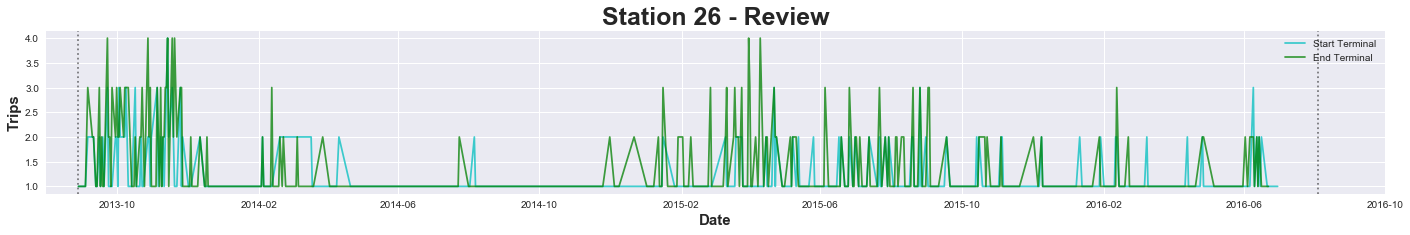

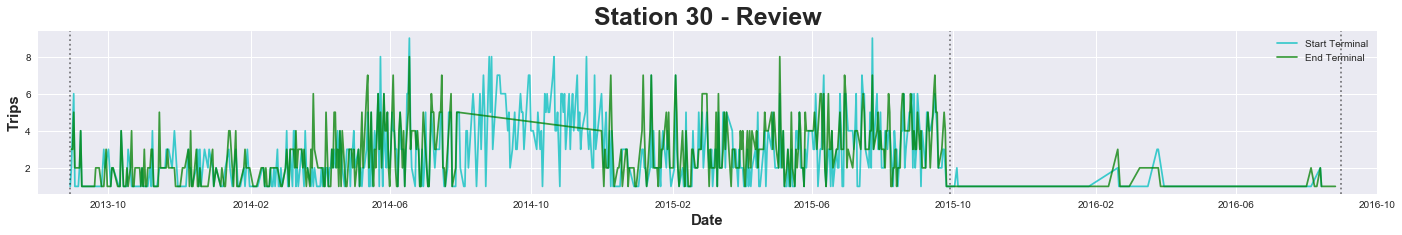

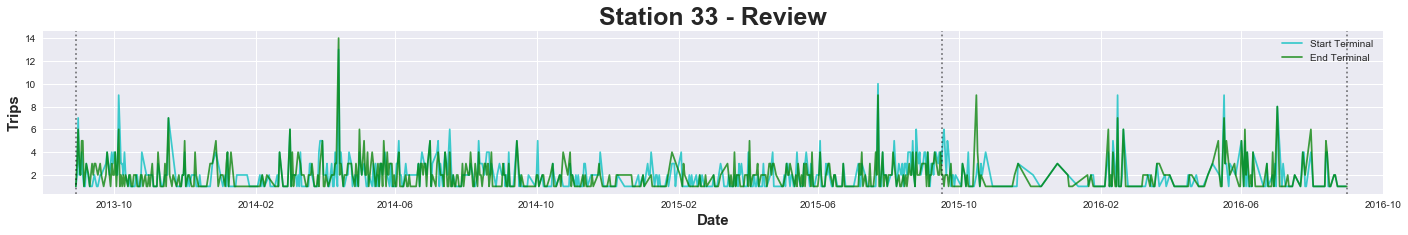

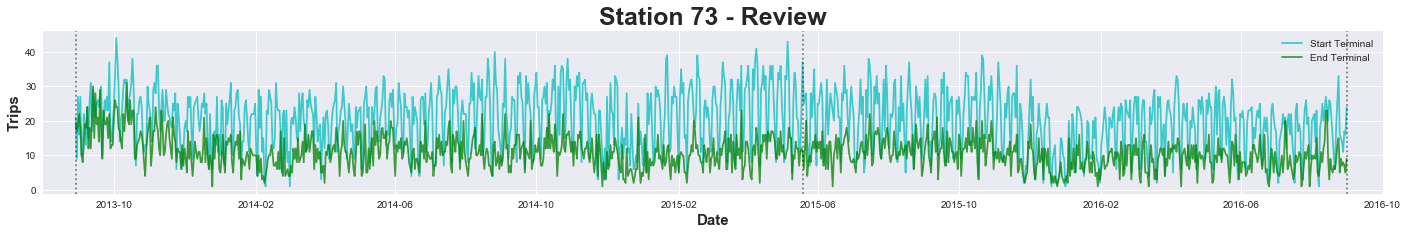

In [22]:

# Station 26 Review
s26_dates = ['2013-08-29', '2016-08-04']
plot_terminal_trips(trip_data, 26, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s26_dates)

# Station 30 Review
s30_dates = ['2013-08-29', '2015-09-28', '2016-08-31']
plot_terminal_trips(trip_data, 30, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s30_dates)

# Station 33 Review
s33_dates = ['2013-08-29', '2015-09-16', '2016-08-31']
plot_terminal_trips(trip_data, 33, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s33_dates)

# Station 73 Review
s73_dates = ['2013-08-29', '2015-05-19', '2016-08-31']
plot_terminal_trips(trip_data, 73,x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s73_dates)

In [35]:
trip_data.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [36]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955557 entries, 0 to 955556
Data columns (total 25 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null category
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
start_area            955557 non-null object
end_area              955557 non-null object
start_zip             955557 non-null int64
end_zip               955557 non-null int64
max_temp              955507 non-null float64
mean_temp             955507 non-null float64
min_temp              955507 non-null float64
max_wind            

In [25]:
print('[%s]\tWriting File...' % datetime.datetime.now().time())
trip_data.to_csv('../clean_data/trip_data_cleaned_zips.csv', encoding='utf-8')
print('\t[%s]\tComplete!' % datetime.datetime.now().time())

[21:45:37.320258]	Writing File...
	[21:45:54.772485]	Complete!


# Load Weather Data

In [26]:
weather_data = pd.DataFrame()
weather_data = pd.read_csv('../clean_data/weather_cleaned_all.csv', parse_dates=['date'], index_col=['date'])

In [27]:
weather_data.head()

,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events,zip_code
date,,,,,,,,,,
2013-08-29,80.0,70.0,64.0,16.0,5.0,16.0,0.0,4.0,NaN,94041
2013-08-29,80.0,71.0,62.0,14.0,6.0,17.0,0.0,5.0,NaN,94063
2013-08-29,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN,94107
2013-08-29,78.0,71.0,64.0,20.0,8.0,23.0,0.0,4.0,NaN,94301
2013-08-29,81.0,72.0,63.0,16.0,7.0,24.0,0.0,4.0,NaN,95113


In [28]:
pd.unique(weather_data.events)

array([nan, 'Rain', 'rain', 'Fog', 'Fog-Rain', 'Rain-Thunderstorm'], dtype=object)

## Append Weather Data to Trips

In [29]:
trip_data.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes,start_area,end_area,start_zip,end_zip
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000,San Francisco,San Francisco,94107,94107
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333,San Francisco,San Francisco,94107,94107
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000,San Francisco,San Francisco,94107,94107


In [30]:
print('[%s]\tAppending Weather Data...' % datetime.datetime.now().time())


trip_data = pd.merge(trip_data, 
                      weather_data, 
                      how='left', 
                      left_on=[trip_data['start_date'].dt.date, 'start_zip'], 
                      right_on=[weather_data.index.date, 'zip_code'])
trip_data.drop(['zip_code'], axis=1, inplace=True)
# test.set_index('Trip ID', inplace=True)




print('\t[%s]\tComplete!' % datetime.datetime.now().time())

[21:45:54.904729]	Appending Weather Data...
	[21:45:59.705068]	Complete!


In [31]:
trip_data.head(3)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [32]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955557 entries, 0 to 955556
Data columns (total 25 columns):
trip_id               955557 non-null int64
duration              955557 non-null int64
start_date            955557 non-null datetime64[ns]
start_station_name    955557 non-null object
start_terminal        955557 non-null int64
end_date              955557 non-null datetime64[ns]
end_station_name      955557 non-null object
end_terminal          955557 non-null int64
bike_id               955557 non-null int64
user_type             955557 non-null category
user_zip              955557 non-null int64
duration_minutes      955557 non-null float64
start_area            955557 non-null object
end_area              955557 non-null object
start_zip             955557 non-null int64
end_zip               955557 non-null int64
max_temp              955507 non-null float64
mean_temp             955507 non-null float64
min_temp              955507 non-null float64
max_wind            

In [33]:
trip_data.columns

Index(['trip_id', 'duration', 'start_date', 'start_station_name',
       'start_terminal', 'end_date', 'end_station_name', 'end_terminal',
       'bike_id', 'user_type', 'user_zip', 'duration_minutes', 'start_area',
       'end_area', 'start_zip', 'end_zip', 'max_temp', 'mean_temp', 'min_temp',
       'max_wind', 'mean_wind', 'max_gust', 'precipitation', 'cloud_cover',
       'events'],
      dtype='object')

In [34]:
trip_data.to_csv('../clean_data/trip_data_cleaned_master.csv', encoding='utf-8')